# Music Preference Analysis

In this notebook, I explore the Chinook database to analyze music listeners' preferences. Multiple tables are merged to link customer information with purchased tracks, and the results are visualized to uncover listening patterns. Finally, an artist recommendation system is developed using the Apriori association rule learning algorithm.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install jupysql
%load_ext sql
%sql sqlite:///Chinook_Sqlite.sqlite

Connecting to 'sqlite:///Chinook_Sqlite.sqlite'

In [3]:
%%sql
SELECT name FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///Chinook_Sqlite.sqlite'

name
Album
Artist
Customer
Employee
Genre
Invoice
InvoiceLine
MediaType
Playlist
PlaylistTrack


## Database to DataFrame
I merge multiple tables from the Chinook Database to construct a DataFrame, where each row represents an invoice containing details about purchased tracks and customers.

In [4]:
%%sql result <<
WITH 
IC AS (
  SELECT Invoice.InvoiceId, Customer.CustomerId, Customer.City, Customer.State, Customer.Country
  FROM Invoice
  JOIN Customer ON Invoice.CustomerId = Customer.CustomerId
),
TG AS (
    WITH
    AA AS (
        SELECT Album.*, Artist.Name AS ArtistName
        FROM Album
        JOIN Artist ON Album.ArtistId = Artist.ArtistId
    )
    SELECT Track.TrackId,
           Track.Name AS TrackName,
           AA.*,
           Genre.GenreId,
           Genre.Name AS GenreName
    FROM Track
    LEFT JOIN AA ON Track.AlbumId = AA.AlbumId
    LEFT JOIN Genre ON Track.GenreId = Genre.GenreId
)
SELECT 
  InvoiceLine.InvoiceLineId,
  InvoiceLine.UnitPrice,
  InvoiceLine.Quantity,
  IC.*,
  TG.*
FROM InvoiceLine
LEFT JOIN TG ON InvoiceLine.TrackId = TG.TrackId
LEFT JOIN IC ON InvoiceLine.InvoiceId = IC.InvoiceId;

Running query in 'sqlite:///Chinook_Sqlite.sqlite'

In [5]:
df = result.DataFrame()

In [6]:
df.to_csv('music_invoice.csv', index=False, encoding='utf-8')

In [7]:
df.head()

,InvoiceLineId,UnitPrice,Quantity,InvoiceId,CustomerId,City,State,Country,TrackId,TrackName,AlbumId,Title,ArtistId,ArtistName,GenreId,GenreName
0,1,0.99,1,1,2,Stuttgart,None,Germany,2,Balls to the Wall,2,Balls to the Wall,2,Accept,1,Rock
1,2,0.99,1,1,2,Stuttgart,None,Germany,4,Restless and Wild,3,Restless and Wild,2,Accept,1,Rock
2,3,0.99,1,2,4,Oslo,None,Norway,6,Put The Finger On You,1,For Those About To Rock We Salute You,1,AC/DC,1,Rock
3,4,0.99,1,2,4,Oslo,None,Norway,8,Inject The Venom,1,For Those About To Rock We Salute You,1,AC/DC,1,Rock
4,5,0.99,1,2,4,Oslo,None,Norway,10,Evil Walks,1,For Those About To Rock We Salute You,1,AC/DC,1,Rock


## Exploratory Data Analysis


In [8]:
df.describe()

,InvoiceLineId,UnitPrice,Quantity,InvoiceId,CustomerId,TrackId,AlbumId,ArtistId,GenreId
count,2240.000000,2240.000000,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1120.500000,1.039554,1.0,206.868750,29.974107,1717.734375,138.558482,92.128571,5.249554
std,646.776623,0.217069,0.0,119.134877,17.018715,993.797999,80.752497,53.080845,5.690055
min,1.000000,0.990000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,560.750000,0.990000,1.0,103.000000,15.000000,874.000000,70.000000,51.000000,1.000000
50%,1120.500000,0.990000,1.0,207.000000,30.000000,1708.000000,141.000000,90.000000,3.000000
75%,1680.250000,0.990000,1.0,311.000000,45.000000,2560.000000,206.250000,132.000000,7.000000
max,2240.000000,1.990000,1.0,412.000000,59.000000,3500.000000,344.000000,272.000000,24.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InvoiceLineId  2240 non-null   int64  
 1   UnitPrice      2240 non-null   float64
 2   Quantity       2240 non-null   int64  
 3   InvoiceId      2240 non-null   int64  
 4   CustomerId     2240 non-null   int64  
 5   City           2240 non-null   object 
 6   State          1140 non-null   object 
 7   Country        2240 non-null   object 
 8   TrackId        2240 non-null   int64  
 9   TrackName      2240 non-null   object 
 10  AlbumId        2240 non-null   int64  
 11  Title          2240 non-null   object 
 12  ArtistId       2240 non-null   int64  
 13  ArtistName     2240 non-null   object 
 14  GenreId        2240 non-null   int64  
 15  GenreName      2240 non-null   object 
dtypes: float64(1), int64(8), object(7)
memory usage: 280.1+ KB


In [10]:
df.nunique()

InvoiceLineId    2240
UnitPrice           2
Quantity            1
InvoiceId         412
CustomerId         59
City               53
State              25
Country            24
TrackId          1984
TrackName        1888
AlbumId           304
Title             304
ArtistId          165
ArtistName        165
GenreId            24
GenreName          24
dtype: int64

In [11]:
# Count by country
country_counts = df['Country'].value_counts()
print(country_counts)

Country
USA               494
Canada            304
France            190
Brazil            190
Germany           152
United Kingdom    114
Portugal           76
Czech Republic     76
India              74
Ireland            38
Norway             38
Belgium            38
Australia          38
Netherlands        38
Spain              38
Chile              38
Sweden             38
Finland            38
Denmark            38
Italy              38
Poland             38
Austria            38
Hungary            38
Argentina          38
Name: count, dtype: int64


In [12]:
# Count top 10 music genres
top_n = 10
genre_counts = df['GenreName'].value_counts()

top_genres = genre_counts.nlargest(top_n)
others_sum = genre_counts.iloc[top_n:].sum()

genre_final = top_genres.copy()
genre_final['others'] = others_sum
print(genre_final)

GenreName
Rock                  835
Latin                 386
Metal                 264
Alternative & Punk    244
Jazz                   80
Blues                  61
TV Shows               47
R&B/Soul               41
Classical              41
Reggae                 30
others                211
Name: count, dtype: int64


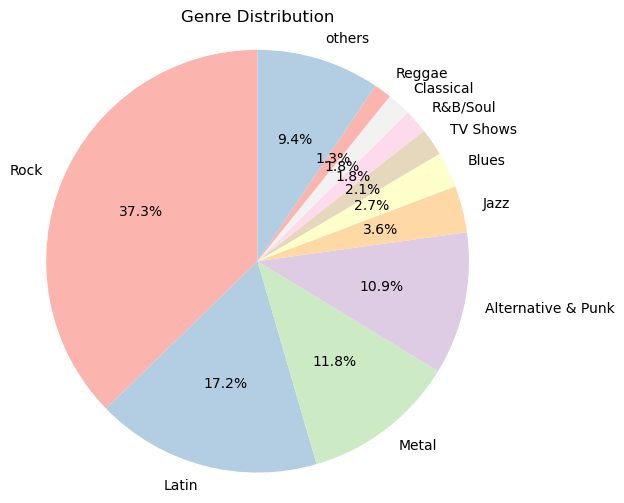

In [13]:
# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    genre_final,
    labels = genre_final.index,
    autopct = '%1.1f%%',
    startangle = 90,
    colors = plt.cm.Pastel1.colors
)
plt.title('Genre Distribution')
plt.axis('equal')

plt.show()

* Rock(37.3%) is the most frequently purchased genre in the dataset, followed by Latin(17.2%), Metal(11.8%), and Alternative & Punk(10.9%).
* In all five countries with the largest number of customers, Rock was the most purchased genre. In the United States, Canada, and Brazil, the next most popular genres were Latin, Metal, and Alternative & Punk. In France, Alternative & Punk ranked second, while in Germany, Metal was the second most purchased genre.


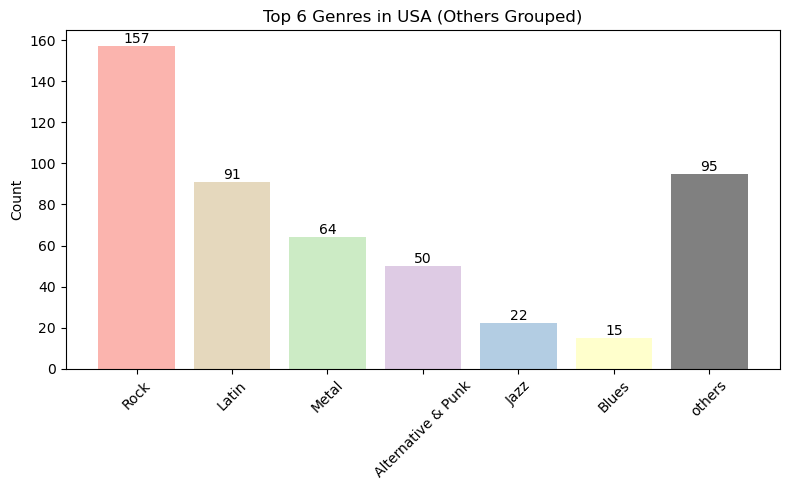

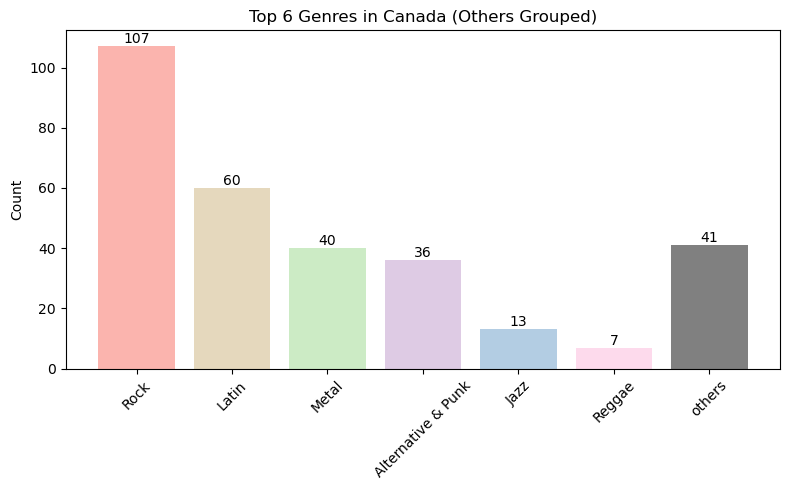

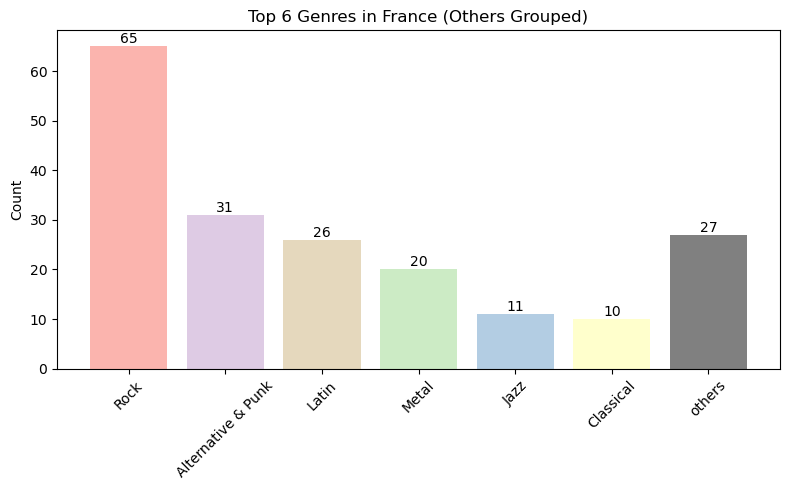

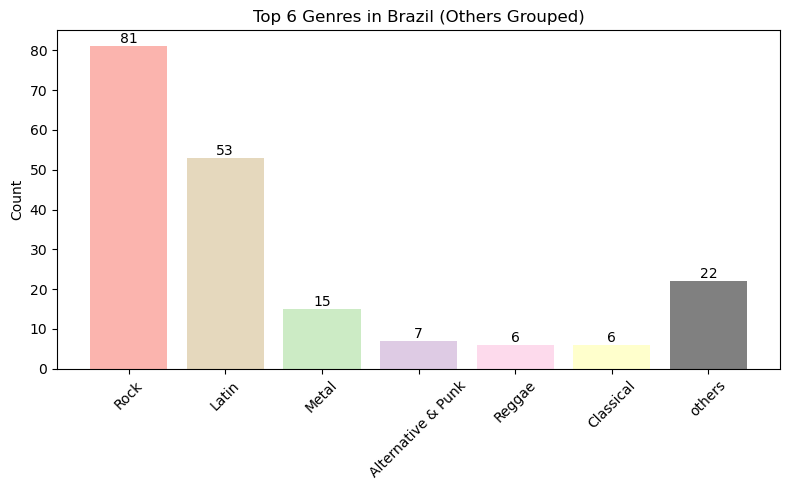

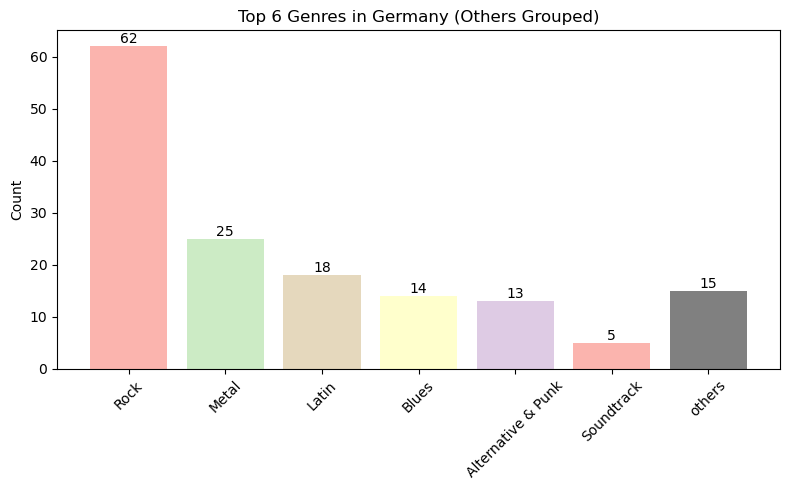

In [14]:
# Pick 5 most observed countries
country_list = country_counts.nlargest(5).index.tolist()

# Choose a color palette
all_genres = df['GenreName'].unique()
color_palette = plt.cm.Pastel1.colors
genre_color_map = {genre: color_palette[i % len(color_palette)] for i, genre in enumerate(all_genres)}

top_n = 6

# Loop through each country
for c in country_list:
    # Filter data for the current country

    df_c = df[df['Country'] == c]
    
    genre_counts = df_c['GenreName'].value_counts()

    top_genres = genre_counts.nlargest(top_n)
    others_sum = genre_counts.iloc[top_n:].sum()

    genre_final = top_genres.copy()
    genre_final['others'] = others_sum

    # Assign colors using the fixed map
    bar_colors = [genre_color_map.get(genre, 'gray') for genre in genre_final.index]

    # Plot pie chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(genre_final.index, genre_final.values, color=bar_colors)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

    plt.title(f'Top {top_n} Genres in {c} (Others Grouped)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Artist Recommendation System

I develop an artist recommendation system using the Apriori association rule learning algorithm.

In [15]:
!pip install apyori

In [24]:
# Group artists per customer
customer_artist = (
    df.groupby('CustomerId')['ArtistName']
    .apply(lambda x: list(set(x)))  # convert to set to remove duplicates
    .reset_index()
)


In [25]:
c_a_list = customer_artist['ArtistName'].tolist()

In [26]:
print(c_a_list)

[['Frank Zappa & Captain Beefheart', 'Academy of St. Martin in the Fields & Sir Neville Marriner', 'Ozzy Osbourne', 'Chico Science & Nação Zumbi', 'Led Zeppelin', 'Kiss', 'Battlestar Galactica (Classic)', 'U2', 'Cláudio Zoli', 'Cidade Negra', 'Marcos Valle', "Guns N' Roses", 'Berliner Philharmoniker & Hans Rosbaud', 'Os Paralamas Do Sucesso', 'Various Artists'], ['Metallica', 'Pearl Jam', 'Frank Zappa & Captain Beefheart', 'Accept', 'Queen', 'Led Zeppelin', "Paul D'Ianno", 'Buddy Guy', 'Passengers', 'Bruce Dickinson', 'Kiss', 'The Who', 'U2', 'Antônio Carlos Jobim', 'Marcos Valle', 'Eric Clapton', 'Various Artists'], ['Metallica', 'Smashing Pumpkins', 'The Who', 'Michael Tilson Thomas & San Francisco Symphony', 'Bruce Dickinson', 'Body Count', 'Miles Davis', 'BackBeat', 'Felix Schmidt, London Symphony Orchestra & Rafael Frühbeck de Burgos', 'Toquinho & Vinícius', 'Gene Krupa', 'Antal Doráti & London Symphony Orchestra', 'Lost', 'Billy Cobham', 'Black Sabbath', 'Antônio Carlos Jobim', '

In [30]:
from apyori import apriori

rules = apriori(c_a_list, min_support=0.05, min_confidence=0.3, min_lift = 3, min_length = 2, max_length =2)

In [31]:
results = list(rules)

In [32]:
results

[RelationRecord(items=frozenset({'AC/DC', 'Accept'}), support=0.05084745762711865, ordered_statistics=[OrderedStatistic(items_base=frozenset({'AC/DC'}), items_add=frozenset({'Accept'}), confidence=0.5, lift=7.375), OrderedStatistic(items_base=frozenset({'Accept'}), items_add=frozenset({'AC/DC'}), confidence=0.75, lift=7.374999999999999)]),
 RelationRecord(items=frozenset({'AC/DC', 'Aerosmith'}), support=0.05084745762711865, ordered_statistics=[OrderedStatistic(items_base=frozenset({'AC/DC'}), items_add=frozenset({'Aerosmith'}), confidence=0.5, lift=7.375), OrderedStatistic(items_base=frozenset({'Aerosmith'}), items_add=frozenset({'AC/DC'}), confidence=0.75, lift=7.374999999999999)]),
 RelationRecord(items=frozenset({'AC/DC', 'Lulu Santos'}), support=0.05084745762711865, ordered_statistics=[OrderedStatistic(items_base=frozenset({'AC/DC'}), items_add=frozenset({'Lulu Santos'}), confidence=0.5, lift=7.375), OrderedStatistic(items_base=frozenset({'Lulu Santos'}), items_add=frozenset({'AC/D

In [33]:
#putting the results into a DataFrame
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [43]:
results_sorted = resultsinDataFrame.sort_values(by=['Support', 'Lift'], ascending =[False, False])
results_sorted_cleaned = results_sorted[~(results_sorted['Right Hand Side'] == 'Various Artists')]
results_sorted_cleaned.head(10)

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
252,Red Hot Chili Peppers,Santana,0.101695,1.000000,7.375000
243,R.E.M.,R.E.M. Feat. Kate Pearson,0.101695,0.400000,3.933333
254,Rush,Santana,0.084746,1.000000,7.375000
59,Chico Buarque,Miles Davis,0.084746,0.454545,3.352273
239,Pearl Jam,Queen,0.084746,0.833333,3.277778
241,Planet Hemp,Queen,0.084746,0.833333,3.277778
84,Creedence Clearwater Revival,Santana,0.084746,0.416667,3.072917
32,BackBeat,Billy Cobham,0.067797,1.000000,14.750000
33,BackBeat,Black Label Society,0.067797,1.000000,14.750000
45,Billy Cobham,Black Label Society,0.067797,1.000000,14.750000


* The results highlight the top 10 most frequently purchased artists (Left-Hand Side) and the artists that are commonly purchased together with them (Right-Hand Side).
* For example, 10.16% of customers purchased tracks by Red Hot Chili Peppers (Support), and all of them also purchased tracks by Santana (Confidence = 1). The lift value of 7.37 indicates that listeners of Red Hot Chili Peppers are over seven times more likely to purchase Santana’s tracks compared to a randomly selected listener.
